In [2]:
# Create directories for outputs
import os
for folder in ['figures/raw', 'figures/scaled', 'figures/shapelets', 'figures/pca', 'figures/ridge', 'figures/deep', 'figures/interpgn', 'models/ridge', 'models/deep', 'models/interpgn']:
    os.makedirs(folder, exist_ok=True)

# Import all relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# Add custom module paths
import sys
sys.path.append("models")
sys.path.append("utils")


In [3]:
# Load data
hcp_data = np.load('hcp_data.npy')  # (500, 92, 1200)
roi_info = pd.read_csv('roi_info_cleaned.csv')
behaviour_data = pd.read_csv('behavior_data_with_headers_cleaned.csv')

# Print shapes
print("fMRI data shape:", hcp_data.shape)
print("ROI info shape:", roi_info.shape)
print("Behavioral data shape:", behaviour_data.shape)
display(behaviour_data.head())


fMRI data shape: (500, 92, 1200)
ROI info shape: (92, 9)
Behavioral data shape: (500, 35)


,Age_in_Yrs,MMSE_Score,PicSeq_Unadj,PicSeq_AgeAdj,CardSort_Unadj,CardSort_AgeAdj,Flanker_Unadj,Flanker_AgeAdj,PMAT24_A_CR,PMAT24_A_SI,...,SCPT_SEN,SCPT_SPEC,SCPT_LRNR,IWRD_TOT,IWRD_RTC,ListSort_Unadj,ListSort_AgeAdj,Language_Task_Acc,Relational_Task_Acc,WM_Task_Acc
0,27.0,29.0,110.61,103.45,123.75,109.92,112.56,101.90,17.0,2.0,...,0.9833,0.9583,11.0,35.0,1442.00,108.06,98.44,80.417,96.250,85.425
1,33.0,30.0,125.71,125.19,111.14,100.77,121.18,113.51,7.0,12.0,...,0.8667,0.9167,9.0,37.0,1450.75,108.06,102.63,97.222,80.417,91.138
2,27.0,30.0,109.04,101.69,129.84,115.18,126.53,114.18,23.0,0.0,...,1.0000,0.9750,7.0,38.0,1240.00,117.39,108.26,100.000,96.667,96.867
3,35.0,28.0,84.68,70.00,105.19,94.30,101.85,92.33,11.0,8.0,...,0.9833,0.9750,15.0,37.0,1579.50,93.90,84.01,83.611,53.333,73.017
4,22.0,29.0,105.60,97.37,119.76,105.69,107.04,96.19,14.0,5.0,...,0.9167,0.9417,8.0,30.0,1390.00,130.38,123.73,82.917,54.167,84.937


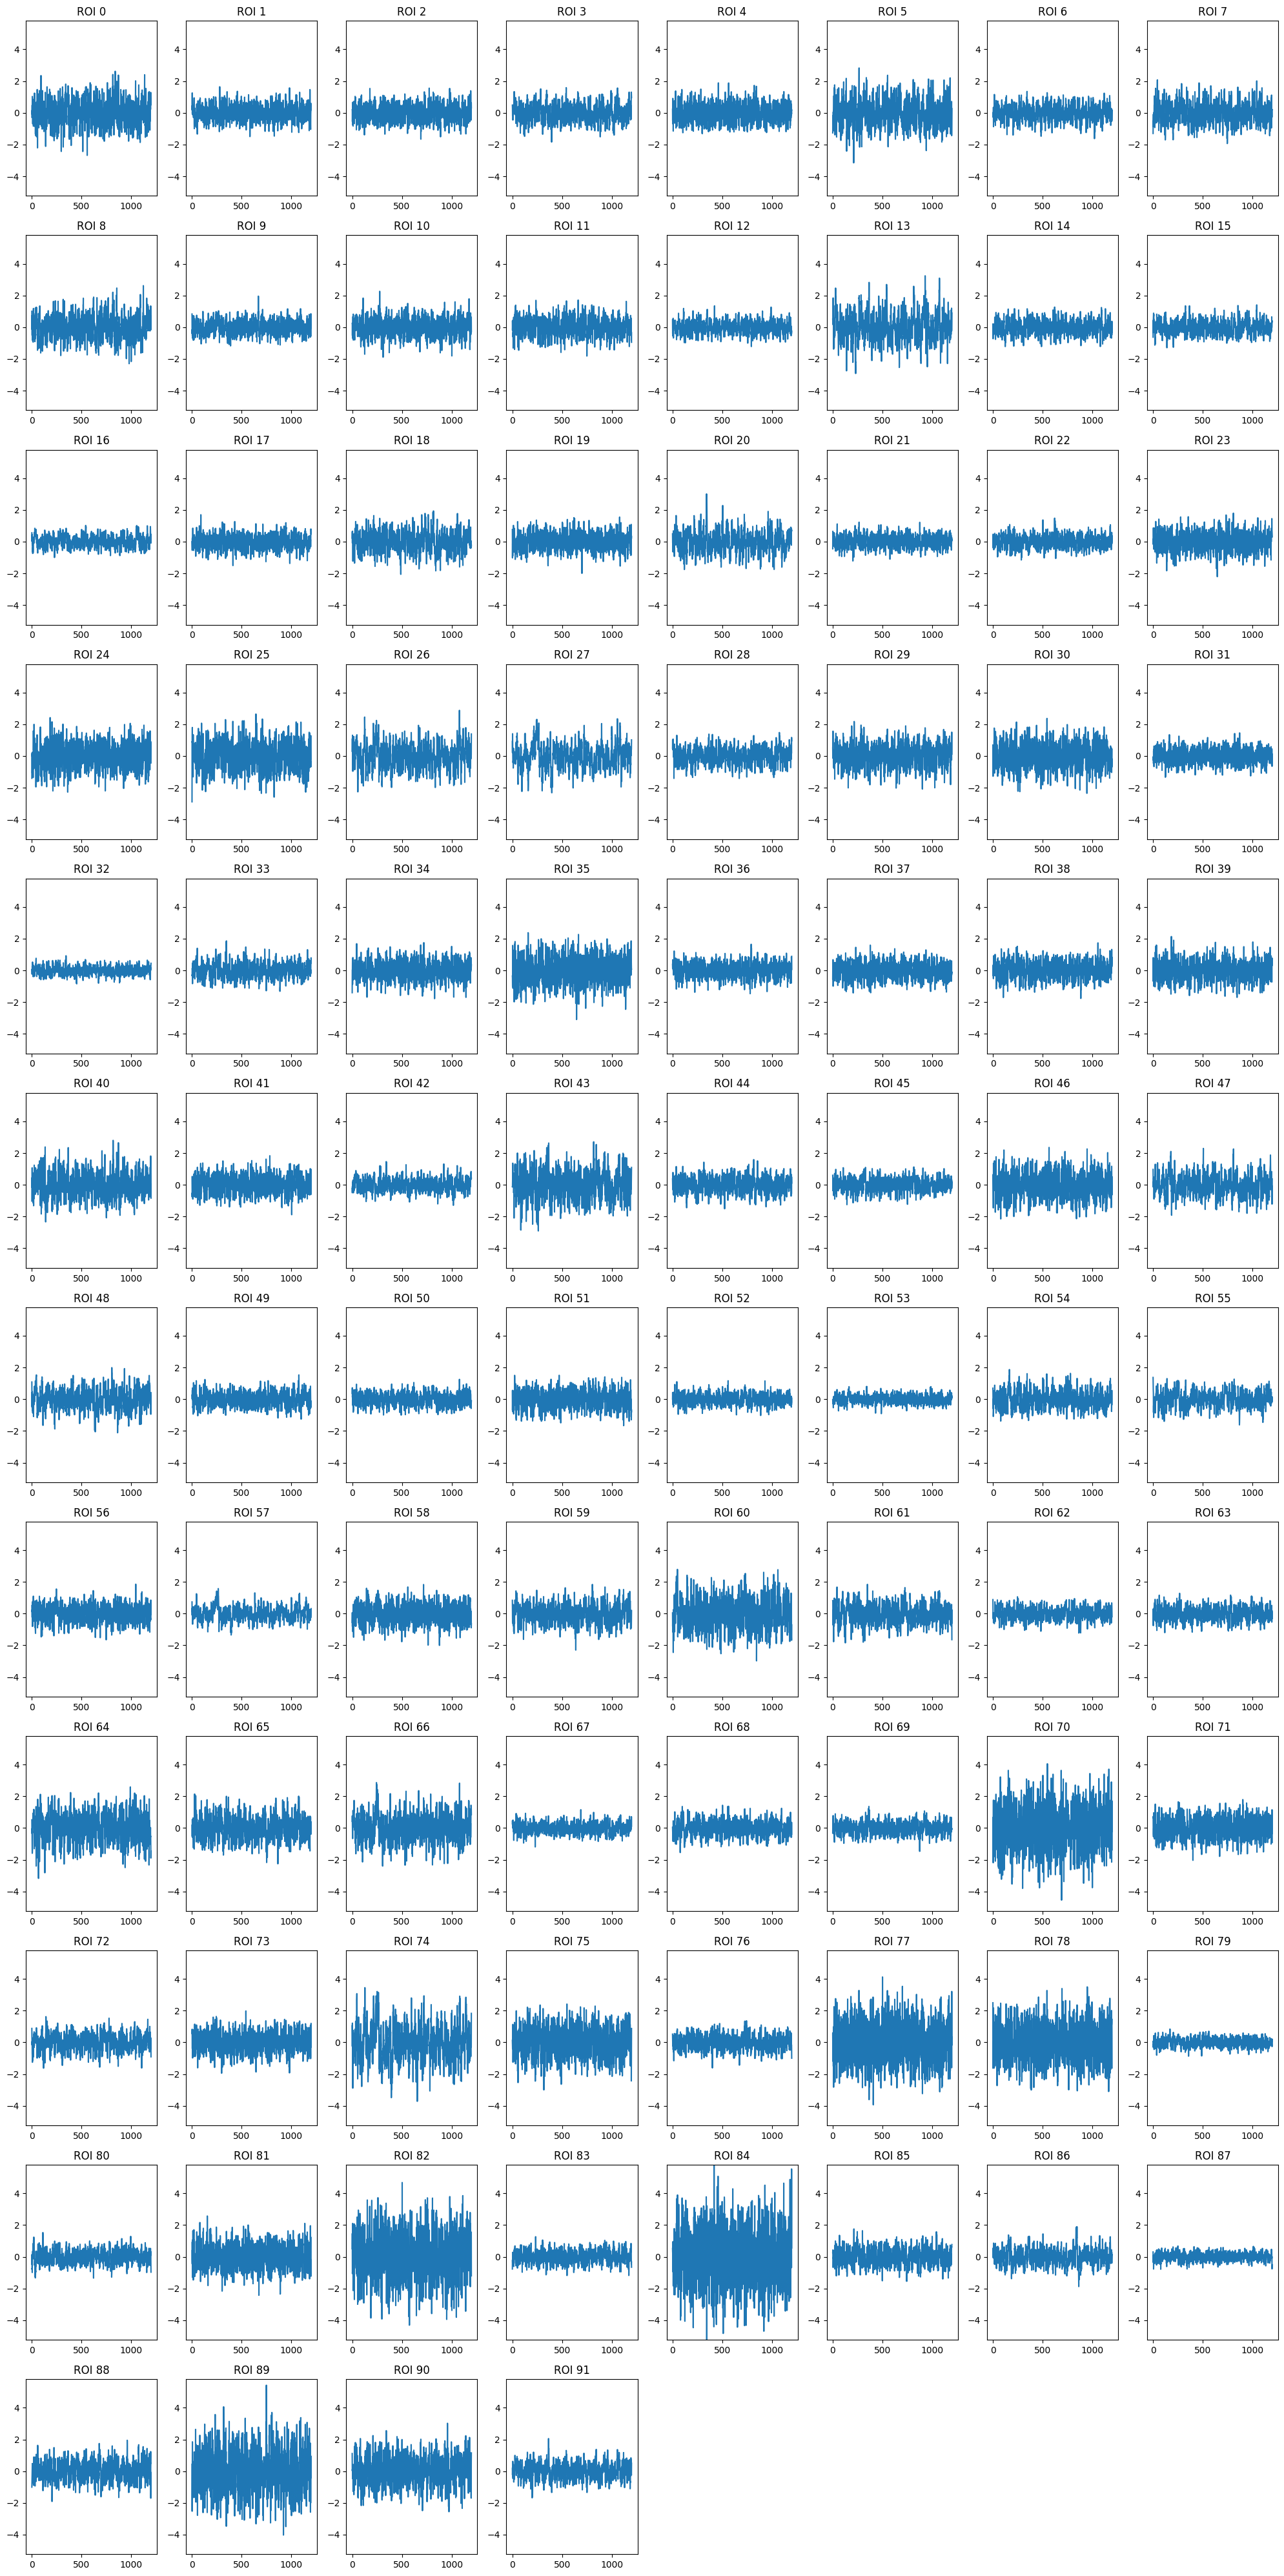

In [5]:
# Plot time series for one subject across all ROIs with fixed Y-axis
subject_idx = 0
n_regions = hcp_data.shape[1]

# Calculate global Y-axis limits across all ROIs for the subject
global_min = hcp_data[subject_idx].min()
global_max = hcp_data[subject_idx].max()

plt.figure(figsize=(20, 40))
for i in range(n_regions):
    plt.subplot(12, 8, i + 1)
    plt.plot(hcp_data[subject_idx, i])
    plt.title(f"ROI {i}")
    plt.ylim(global_min, global_max)  # Fixed Y-axis range
    plt.tight_layout()
plt.savefig("figures/raw/subject0_roi_timeseries_fixed_y.png")
plt.show()



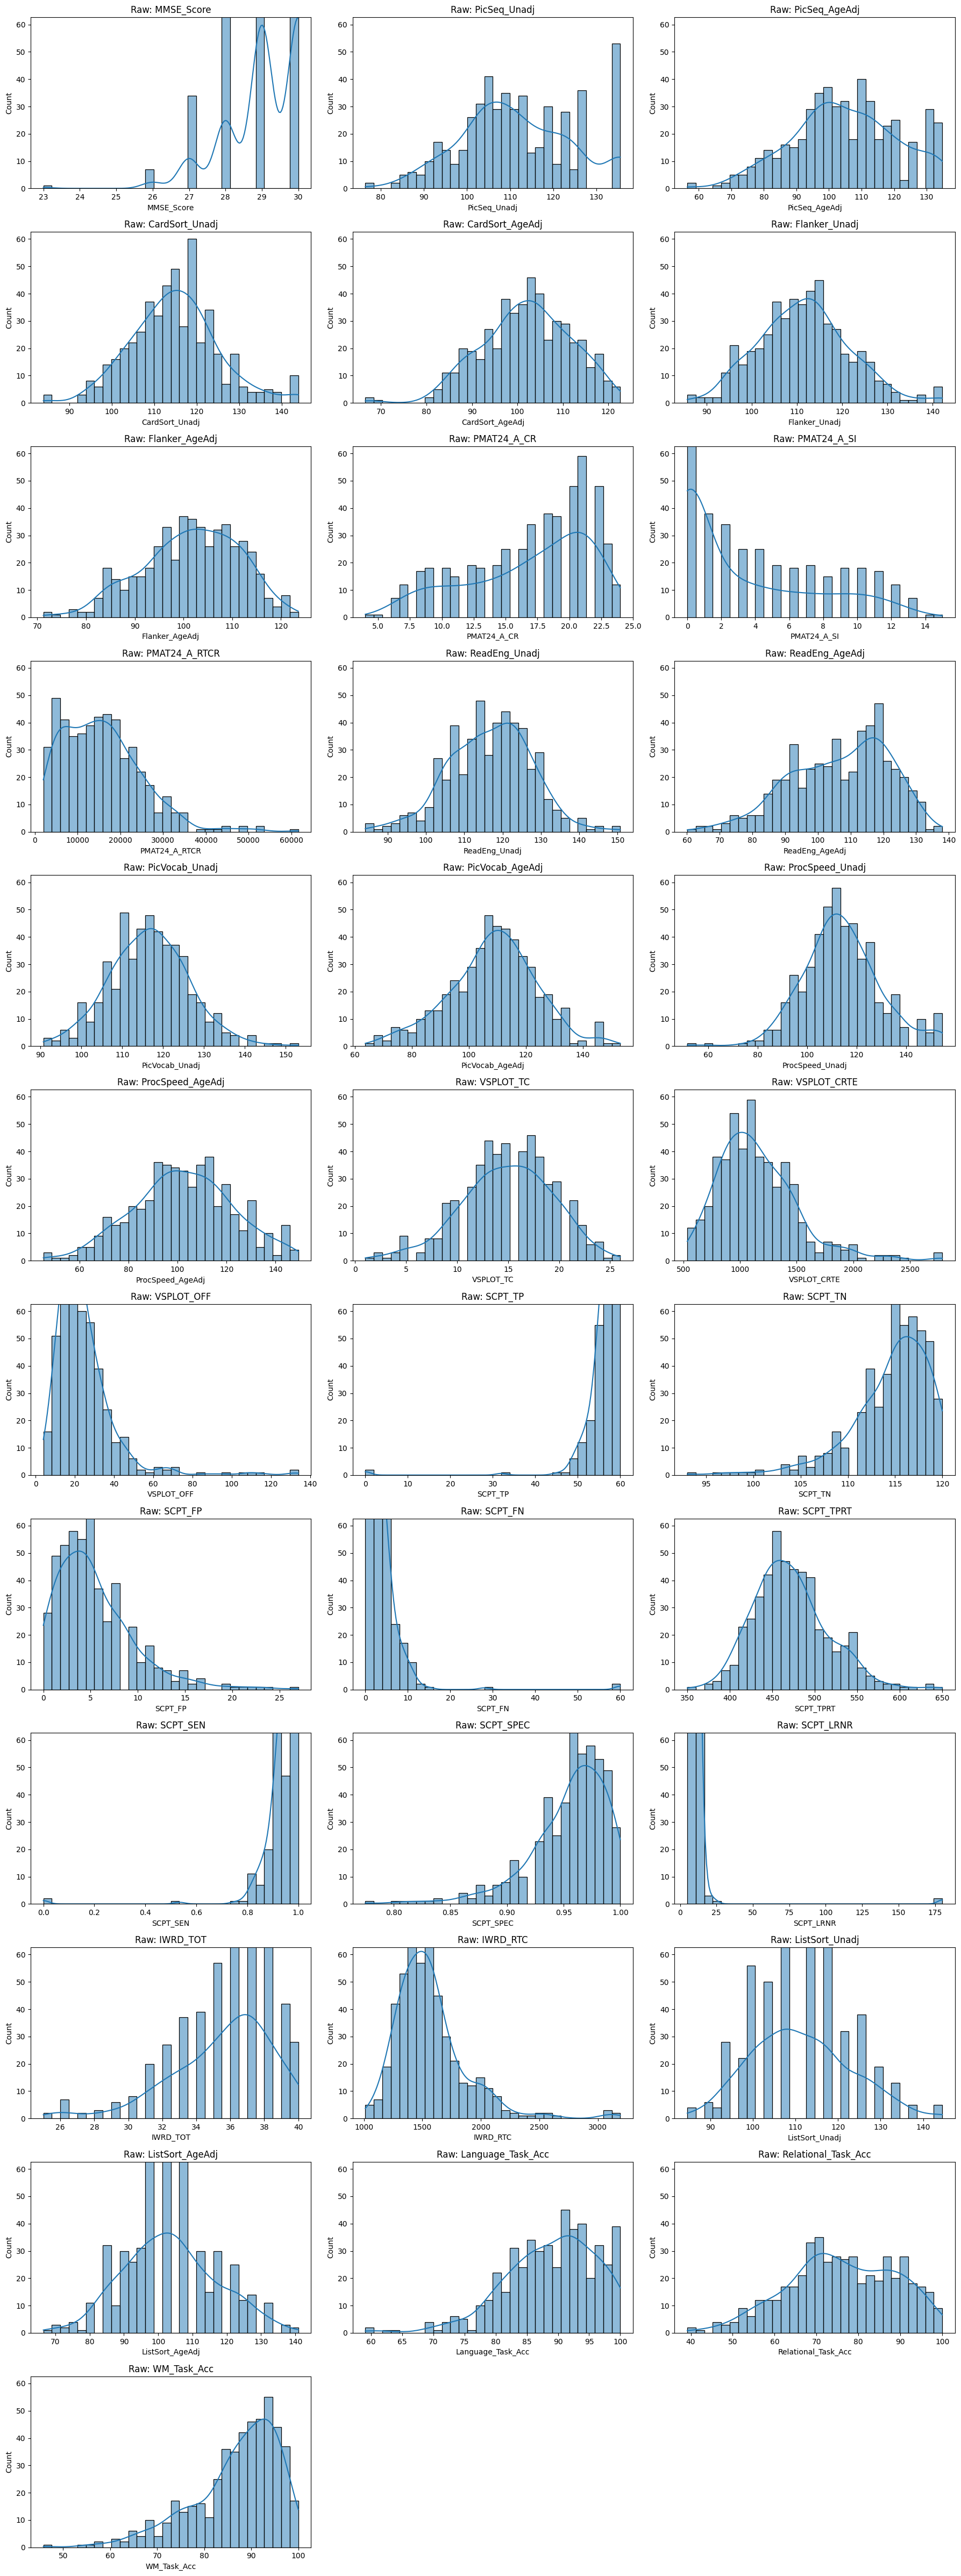

In [6]:
# Get maximum Y value from all histograms
max_freq = max(
    sns.histplot(behaviour_data[col], bins=30, kde=True).get_lines()[0].get_ydata().max()
    for col in numeric_cols
)

plt.close('all')  # Clear those temporary plots

# Now replot with fixed Y-axis
plt.figure(figsize=(18, n_rows * 4))
for idx, column in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(behaviour_data[column], bins=30, kde=True)
    plt.ylim(0, max_freq)
    plt.title(f"Raw: {column}")
plt.tight_layout()
plt.savefig("figures/raw/behavioral_distributions_fixed_y.png")
plt.show()


In [8]:
# ================================
# Scale hcp_data (ROI time series)
# ================================
hcp_data_scaled = np.empty_like(hcp_data)
for s in range(hcp_data.shape[0]):
    for r in range(hcp_data.shape[1]):
        hcp_data_scaled[s, r] = StandardScaler().fit_transform(hcp_data[s, r].reshape(-1, 1)).flatten()


In [10]:
# ===================================
# Impute + Scale Behavioral Data
# ===================================
from sklearn.impute import SimpleImputer


# Impute missing values
imputer = SimpleImputer(strategy="mean")
behaviour_data_imputed = behaviour_data.copy()
behaviour_data_imputed[numeric_cols] = imputer.fit_transform(behaviour_data[numeric_cols])

# Store raw for comparison
behaviour_data_raw = behaviour_data[numeric_cols].copy()

# Standard scale target variables
scaler = StandardScaler()
behaviour_data_scaled = behaviour_data_imputed.copy()
behaviour_data_scaled[numeric_cols] = scaler.fit_transform(behaviour_data_imputed[numeric_cols])


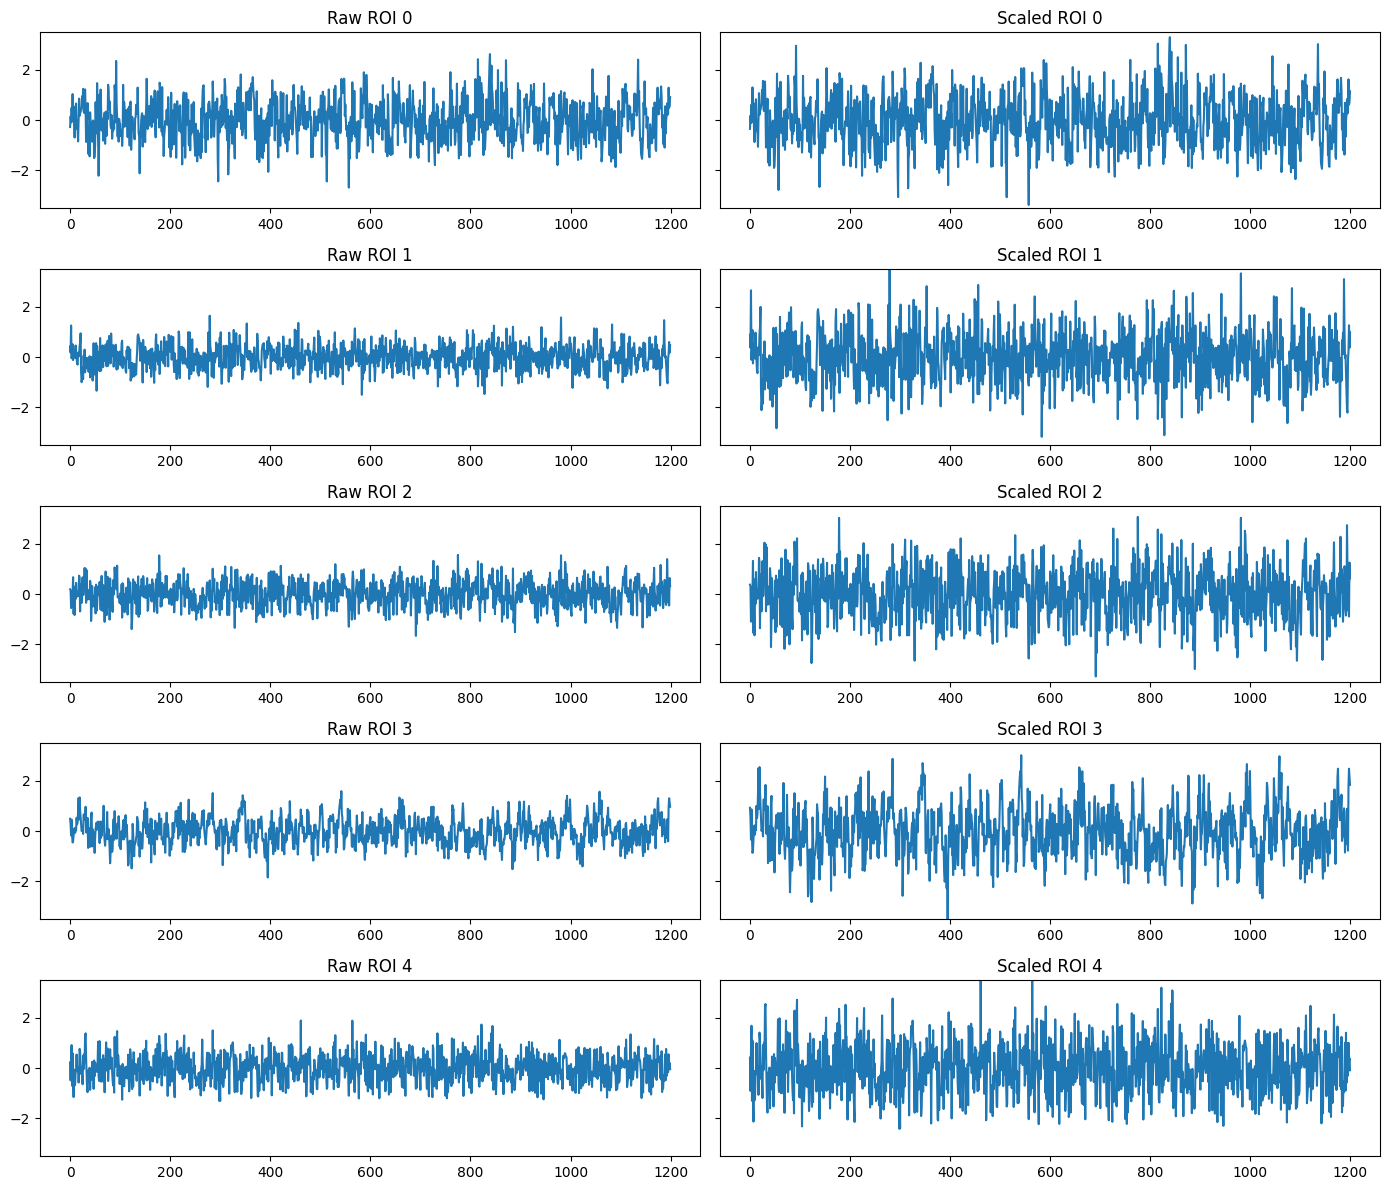

In [12]:
# =======================================================
# Visualize Raw vs Scaled Time Series (5 ROIs, 1 subject)
# =======================================================
example_subject = 0
example_rois = [0, 1, 2, 3, 4]

# Get global min and max for Y-axis (raw and scaled)
ymin = min(hcp_data[example_subject, example_rois].min(), hcp_data_scaled[example_subject, example_rois].min())
ymax = max(hcp_data[example_subject, example_rois].max(), hcp_data_scaled[example_subject, example_rois].max())

fig, axes = plt.subplots(len(example_rois), 2, figsize=(14, 12), sharey=True)
for i, roi in enumerate(example_rois):
    axes[i, 0].plot(hcp_data[example_subject, roi])
    axes[i, 0].set_title(f"Raw ROI {roi}")
    axes[i, 0].set_ylim(ymin, ymax)

    axes[i, 1].plot(hcp_data_scaled[example_subject, roi])
    axes[i, 1].set_title(f"Scaled ROI {roi}")
    axes[i, 1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("figures/preprocessing/roi_timeseries_raw_vs_scaled.png")
plt.show()


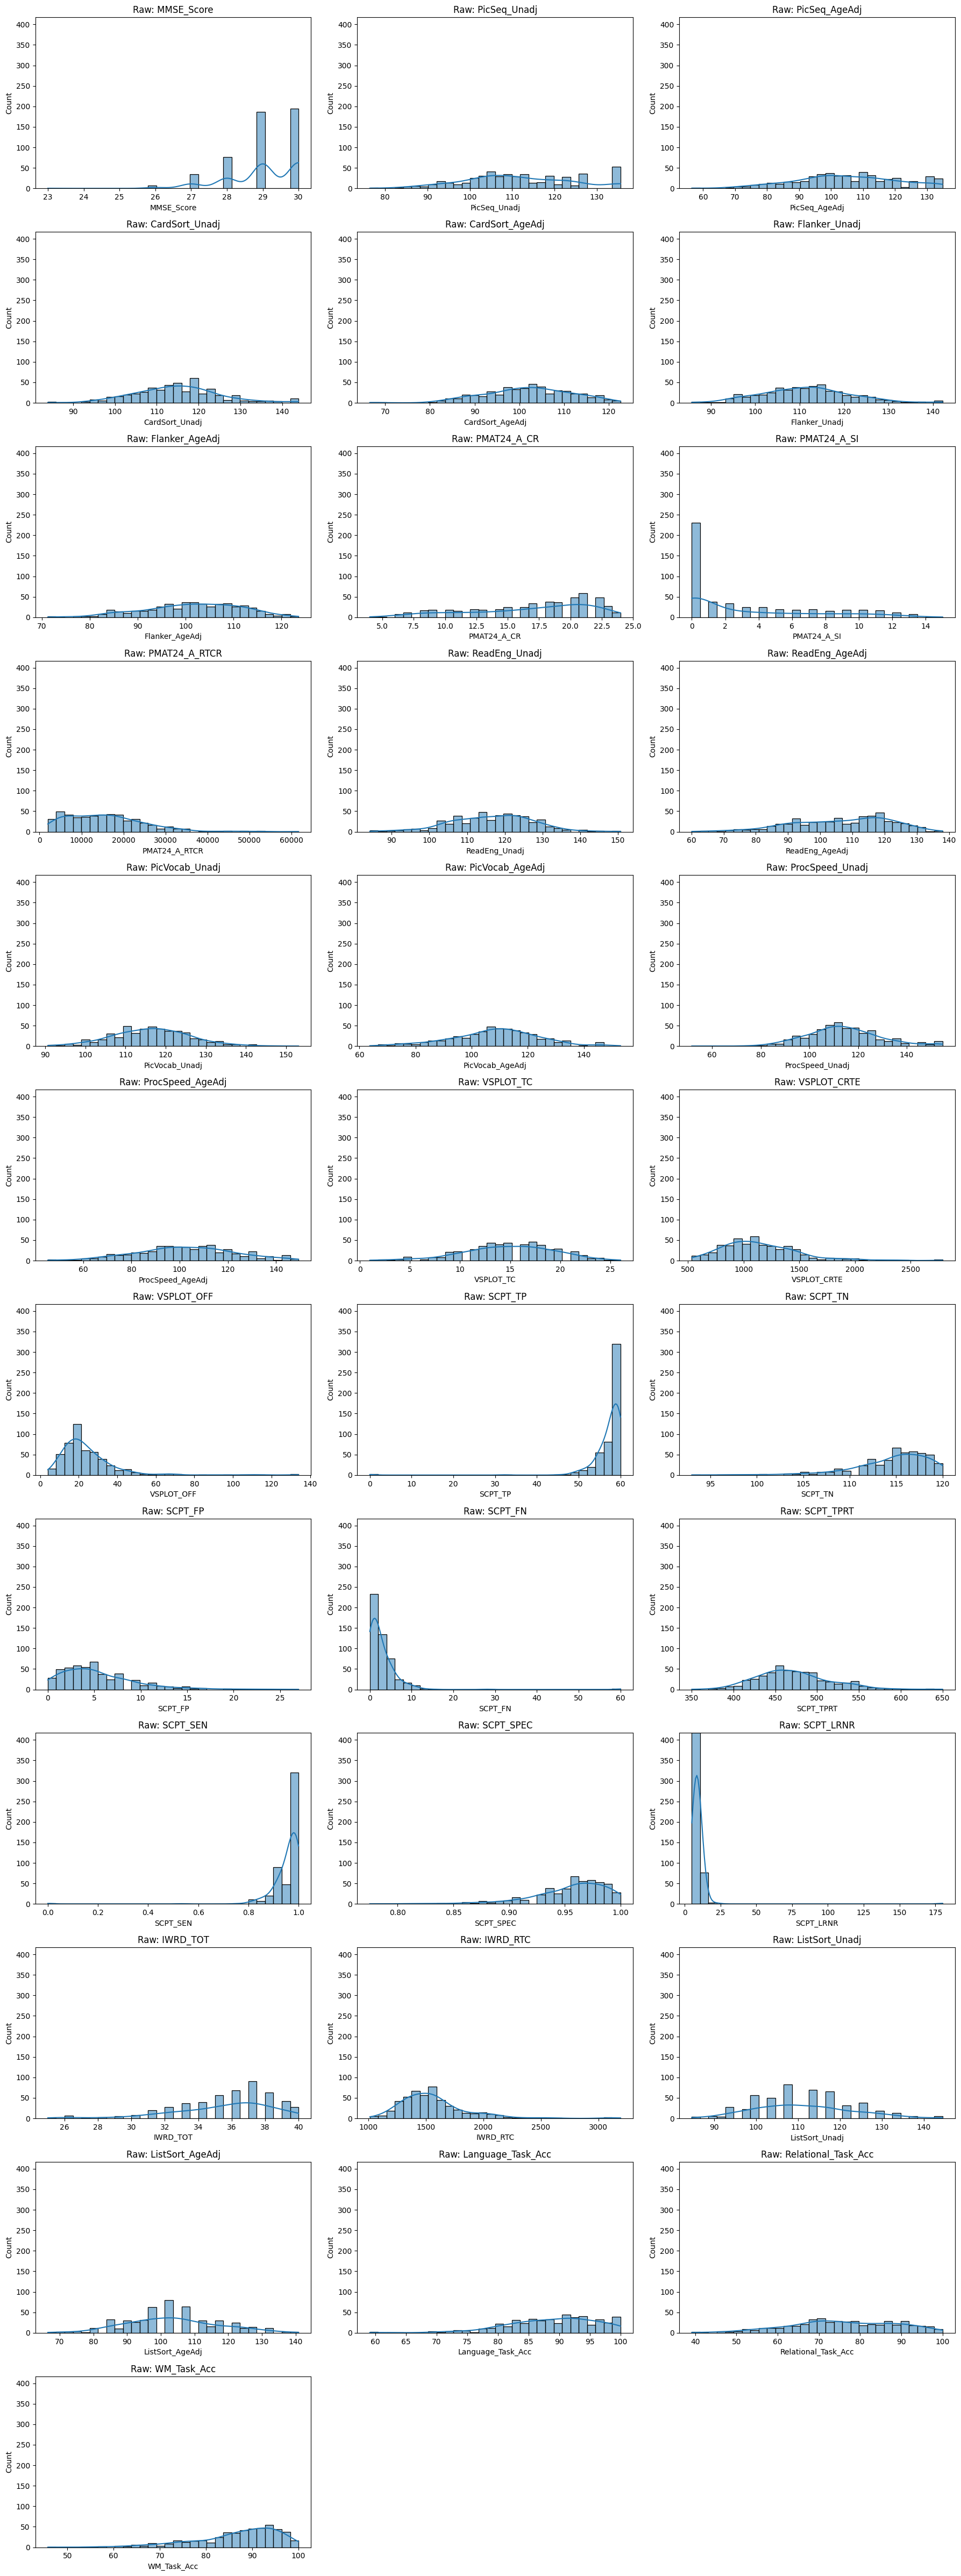

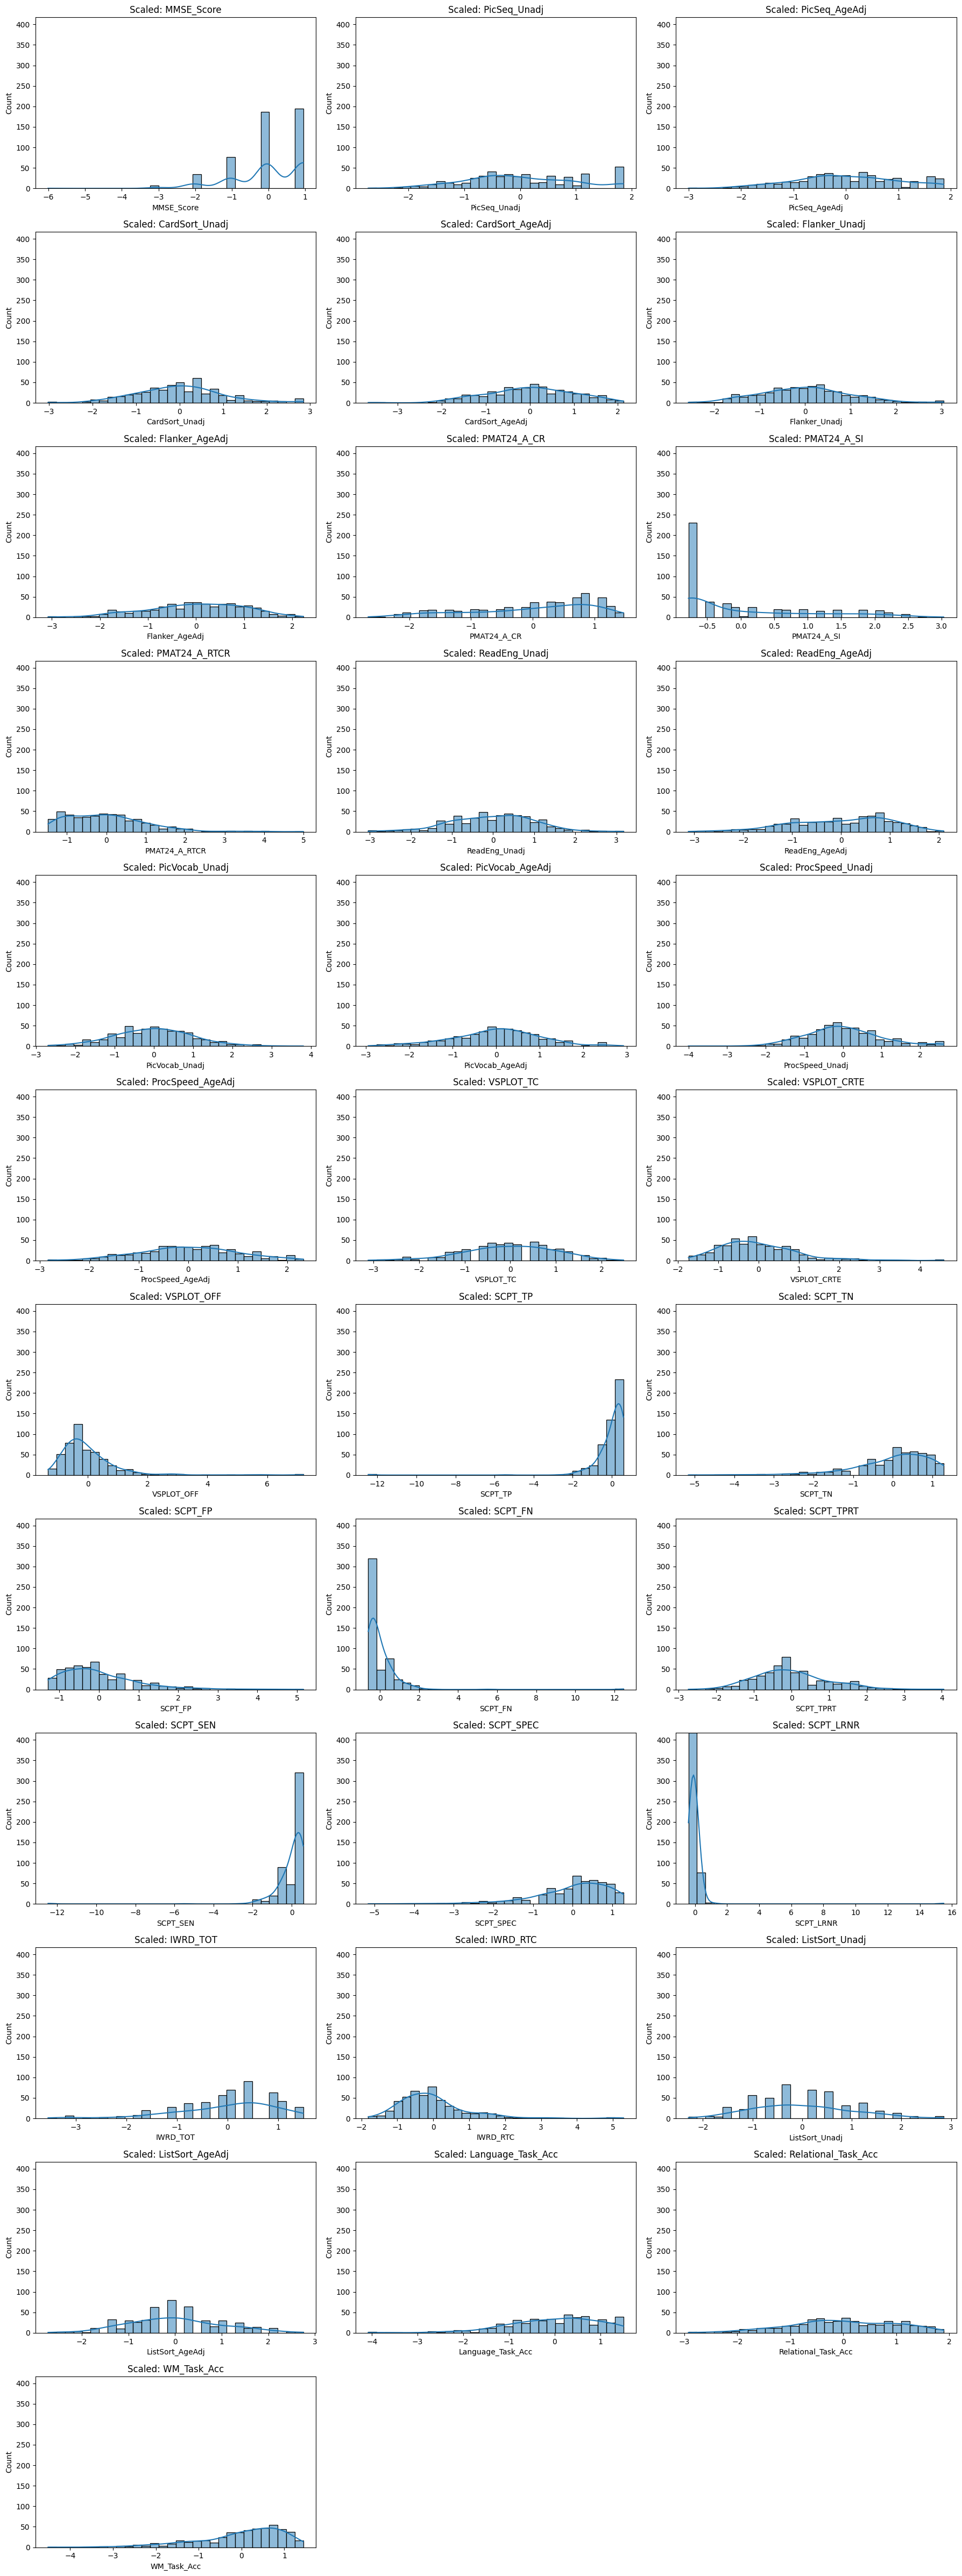

In [13]:
# ==================================================
# Histograms of Behavioral Variables: Raw vs Scaled
# ==================================================
n_cols = 3
n_rows = len(numeric_cols) // n_cols + int(len(numeric_cols) % n_cols != 0)

# Determine shared Y-limit
max_freq = 0
for column in numeric_cols:
    counts, _ = np.histogram(behaviour_data_raw[column].dropna(), bins=30)
    max_freq = max(max_freq, counts.max())

# Plot raw histograms
plt.figure(figsize=(18, n_rows * 4))
for idx, column in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(behaviour_data_raw[column], bins=30, kde=True)
    plt.title(f"Raw: {column}")
    plt.ylim(0, max_freq)
plt.tight_layout()
plt.savefig("figures/preprocessing/behavioral_histograms_raw.png")
plt.show()

# Plot scaled histograms
plt.figure(figsize=(18, n_rows * 4))
for idx, column in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.histplot(behaviour_data_scaled[column], bins=30, kde=True)
    plt.title(f"Scaled: {column}")
    plt.ylim(0, max_freq)
plt.tight_layout()
plt.savefig("figures/preprocessing/behavioral_histograms_scaled.png")
plt.show()


In [15]:
# ========================
# Imports
# ========================
import torch
from models.Shapelet import DistThresholdSBM
from joblib import Parallel, delayed


In [16]:
# ========================
# Shapelet Parameters
# ========================
shapelet_length = 30
num_shapelets = 50
batch_size = 10


In [17]:
# ========================
# Convert hcp_data_scaled to torch tensor
# ========================
hcp_tensor = torch.tensor(hcp_data_scaled, dtype=torch.float32)  # Shape: (500, 92, 1200)
print("Torch tensor shape:", hcp_tensor.shape)


Torch tensor shape: torch.Size([500, 92, 1200])


In [19]:
# ==============================
# Exact Configs for InterpGN Shapelet Model
# ==============================
class Configs:
    def __init__(self):
        self.enc_in = 92                # Number of ROIs
        self.seq_len = 1200            # Timepoints
        self.num_class = 1             # Dummy class count (not used for inference)
        self.epsilon = 1.0             # RBF parameter
        self.distance_func = 'euclidean'
        self.memory_efficient = True
        self.dropout = 0.0
        self.lambda_reg = 0.0
        self.lambda_div = 0.0
        self.sbm_cls = 'linear'        # Options: 'linear', 'bilinear', 'attention'


In [21]:
# Instantiate configs and model
configs = Configs()

# shapelet_len is expressed as fraction of sequence length
shapelet_length = 30
shapelet_fraction = shapelet_length / configs.seq_len  # 30/1200 = 0.025

from models.Shapelet import DistThresholdSBM
# 1 shapelet group with 50 shapelets of length 30
model = DistThresholdSBM(configs=configs, num_shapelet=[50], shapelet_len=[shapelet_fraction])
model.eval()


DistThresholdSBM(
  (shapelets): ModuleList(
    (0): DistThresholdShapelet()
  )
  (output_layer): Linear(in_features=4600, out_features=1, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (distance_func): PairwiseDistance()
)

In [26]:
# ==============================
# Convert hcp_data_scaled to Torch Tensor
# ==============================
hcp_tensor = torch.tensor(hcp_data_scaled, dtype=torch.float32)  # (500, 92, 1200)
print("Original hcp_tensor shape:", hcp_tensor.shape)


Original hcp_tensor shape: torch.Size([500, 92, 1200])


In [31]:
# Pass in (B, C, T) format → hcp_tensor already is!
with torch.no_grad():
    p, d = model.shapelets[0](hcp_tensor[:1])  # Shapelet Layer only!
    print("Aggregated shapelet feature shape (1 subject):", p.shape)


Aggregated shapelet feature shape (1 subject): torch.Size([1, 5386600])
